In [1]:
# prompt: drive mount

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import h5py
import numpy as np
from sklearn.preprocessing import StandardScaler

# Paths
h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_split.h5"
scaler_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaler.pkl"

chunk_size = 100000  # Adjust chunk size based on your RAM

# Initialize Scaler
scaler = StandardScaler()

# Compute scaling parameters on training data
print("Computing scaling parameters...")
with h5py.File(h5_file, "r") as h5f:
    X_train = h5f["X_train"]
    for i in range(0, len(X_train), chunk_size):
        chunk = X_train[i:i + chunk_size]
        scaler.partial_fit(chunk)

# Save the scaler for later use
import pickle
with open(scaler_file, "wb") as f:
    pickle.dump(scaler, f)
print(f"Scaling parameters computed and saved to {scaler_file}.")

Computing scaling parameters...
Scaling parameters computed and saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaler.pkl.


In [3]:
import pickle
import h5py
import numpy as np

# Paths
scaled_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaled_drug_pair_features.h5"

# Load the saved scaler
with open(scaler_file, "rb") as f:
    scaler = pickle.load(f)

chunk_size = 100000  # Adjust chunk size

# Apply scaling and save scaled data
print("Applying scaling and saving to new HDF5 file...")
with h5py.File(h5_file, "r") as h5f, h5py.File(scaled_h5_file, "w") as h5f_out:
    for dataset_name in ["X_train", "X_val", "X_test"]:
        print(f"Processing {dataset_name}...")
        input_dataset = h5f[dataset_name]
        output_dataset = h5f_out.create_dataset(
            dataset_name, shape=input_dataset.shape, dtype=np.float32
        )
        for i in range(0, len(input_dataset), chunk_size):
            chunk = input_dataset[i:i + chunk_size]
            scaled_chunk = scaler.transform(chunk)
            output_dataset[i:i + chunk_size] = scaled_chunk

    # Copy labels directly
    for dataset_name in ["y_train", "y_val", "y_test"]:
        h5f_out.create_dataset(dataset_name, data=h5f[dataset_name])

print(f"Scaled data saved to {scaled_h5_file}.")

Applying scaling and saving to new HDF5 file...
Processing X_train...
Processing X_val...
Processing X_test...
Scaled data saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaled_drug_pair_features.h5.


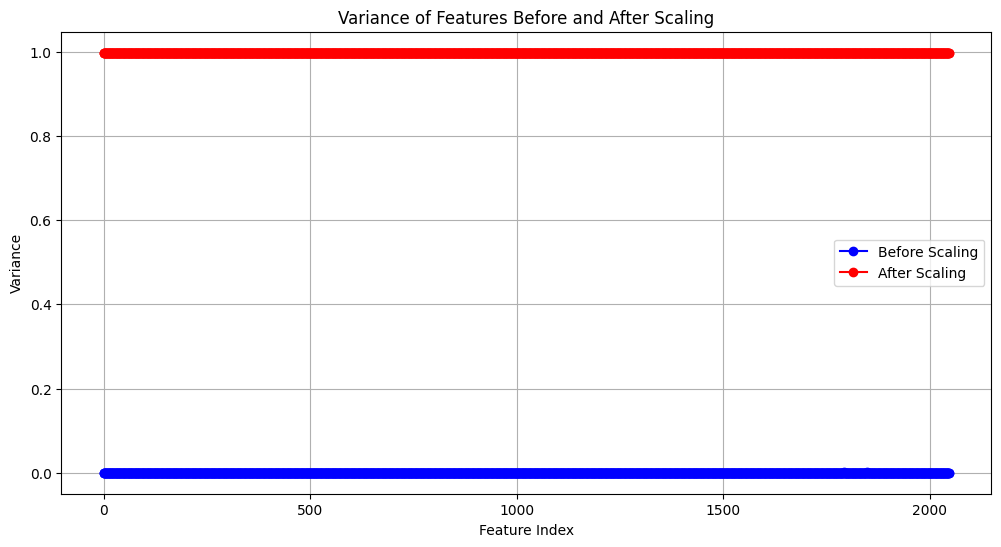

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle

# Paths
h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_split.h5"
scaler_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaler.pkl"
scaled_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaled_drug_pair_features.h5"

# Load the saved scaler
with open(scaler_file, "rb") as f:
    scaler = pickle.load(f)

# Define a function to calculate the variance of each feature in chunks
def calculate_variance(h5_path, dataset_name, scaler=None):
    variances = []
    with h5py.File(h5_path, "r") as h5f:
        dataset = h5f[dataset_name]
        chunk_size = 10000  # Adjust chunk size based on your RAM
        for i in range(0, len(dataset), chunk_size):
            chunk = dataset[i:i + chunk_size]
            if scaler:
                chunk = scaler.transform(chunk)
            variances.append(np.var(chunk, axis=0))
    overall_variance = np.mean(variances, axis=0)
    return overall_variance

# Calculate variance before scaling
var_before = calculate_variance(h5_file, "X_train")

# Calculate variance after scaling
var_after = calculate_variance(scaled_h5_file, "X_train")

# Plot the variances
plt.figure(figsize=(12, 6))
plt.plot(var_before, label='Before Scaling', marker='o', linestyle='-', color='blue')
plt.plot(var_after, label='After Scaling', marker='o', linestyle='-', color='red')
plt.title('Variance of Features Before and After Scaling')
plt.xlabel('Feature Index')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()


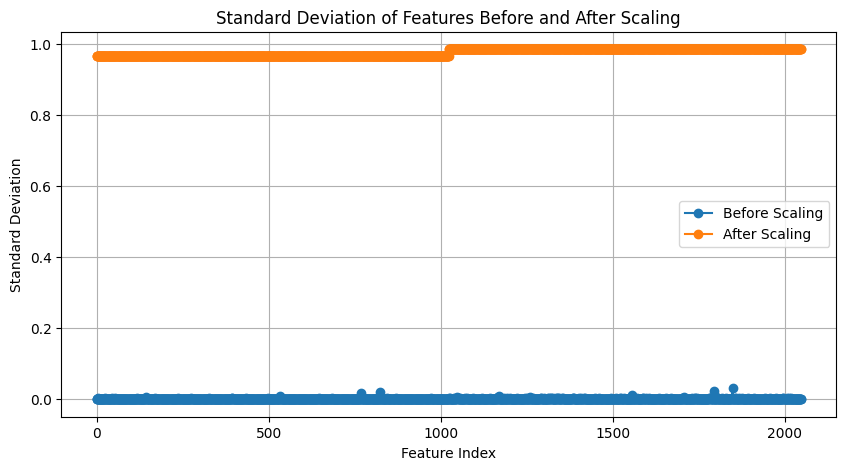

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle

# Paths
h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_split.h5"
scaler_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaler.pkl"
scaled_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaled_drug_pair_features.h5"

# Load the saved scaler
with open(scaler_file, "rb") as f:
    scaler = pickle.load(f)

# Define a function to calculate the standard deviation of each feature in chunks
def calculate_std(h5_path, dataset_name, scaler=None):
    stds = []
    with h5py.File(h5_path, "r") as h5f:
        dataset = h5f[dataset_name]
        chunk_size = 10000  # Adjust chunk size based on your RAM
        for i in range(0, len(dataset), chunk_size):
            chunk = dataset[i:i + chunk_size]
            if scaler:
                chunk = scaler.transform(chunk)
            stds.append(np.std(chunk, axis=0))
    overall_std = np.mean(stds, axis=0)
    return overall_std

# Calculate standard deviation before scaling
std_before = calculate_std(h5_file, "X_train")

# Calculate standard deviation after scaling
std_after = calculate_std(scaled_h5_file, "X_train")

# Plot the standard deviations
plt.figure(figsize=(10, 5))
plt.plot(std_before, label='Before Scaling', marker='o')
plt.plot(std_after, label='After Scaling', marker='o')
plt.title('Standard Deviation of Features Before and After Scaling')
plt.xlabel('Feature Index')
plt.ylabel('Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import StandardScaler
import h5py
import numpy as np

# File paths
scaled_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaled_drug_pair_features.h5"
svd_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/svd_drug_pair_features.h5"

# Parameters
n_components = 200
chunk_size = 10000  # Number of samples per chunk

# Load scaled data
print("Loading scaled dataset...")
with h5py.File(scaled_h5_file, "r") as h5f:
    X_train = h5f["X_train"][:]
    y_train = h5f["y_train"][:]
    X_val = h5f["X_val"][:]
    y_val = h5f["y_val"][:]
    X_test = h5f["X_test"][:]
    y_test = h5f["y_test"][:]

# Initialize SVD with fit_transform using chunks
print(f"\nApplying TruncatedSVD with {n_components} components...")
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit using partial_fit (incremental approach)
for i in range(0, X_train.shape[0], chunk_size):
    chunk = X_train[i:i + chunk_size]
    svd.partial_fit(chunk)

# Transform datasets
X_train_svd = np.vstack([svd.transform(X_train[i:i + chunk_size]) for i in range(0, X_train.shape[0], chunk_size)])
X_val_svd = svd.transform(X_val)
X_test_svd = svd.transform(X_test)

# Save SVD-transformed data
print("\nSaving SVD-transformed data...")
with h5py.File(svd_h5_file, "w") as h5f:
    h5f.create_dataset("X_train", data=X_train_svd)
    h5f.create_dataset("y_train", data=y_train)
    h5f.create_dataset("X_val", data=X_val_svd)
    h5f.create_dataset("y_val", data=y_val)
    h5f.create_dataset("X_test", data=X_test_svd)
    h5f.create_dataset("y_test", data=y_test)

print("SVD transformation and saving completed!")


Loading scaled dataset...
Training Set: (626978, 2048)
Validation Set: (134353, 2048)
Test Set: (134353, 2048)

Applying TruncatedSVD with 200 components...


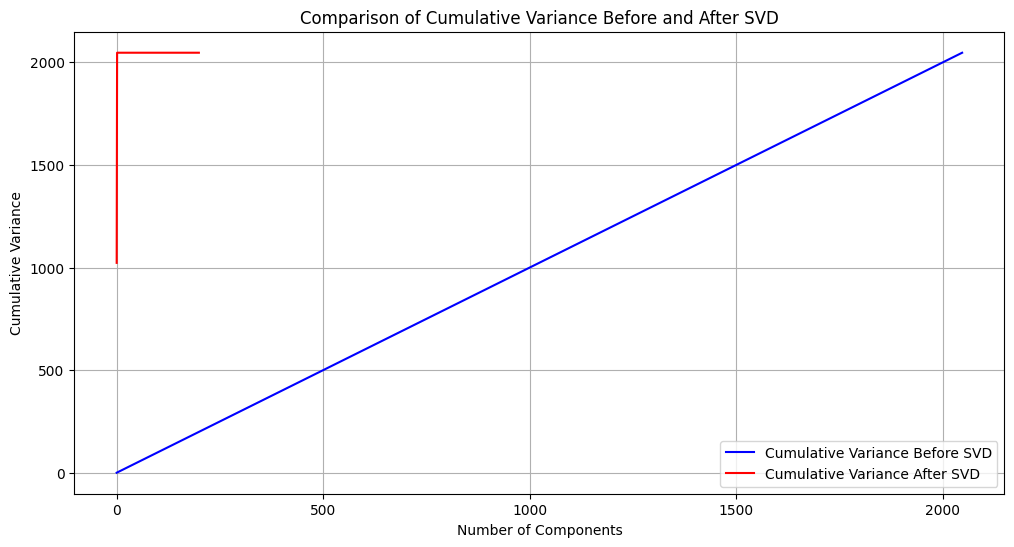

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# File paths
scaled_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaled_drug_pair_features.h5"
svd_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/svd_drug_pair_features.h5"

# Load scaled data
with h5py.File(scaled_h5_file, "r") as h5f:
    X_train = h5f["X_train"][:]

# Load SVD-transformed data
with h5py.File(svd_h5_file, "r") as h5f:
    X_train_svd = h5f["X_train"][:]

# Calculate the variance for each feature before and after SVD
variance_before = np.var(X_train, axis=0)
variance_after = np.var(X_train_svd, axis=0)

# Calculate cumulative variance
cumulative_variance_before = np.cumsum(variance_before)
cumulative_variance_after = np.cumsum(variance_after)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(cumulative_variance_before, label='Cumulative Variance Before SVD', color='blue')
plt.plot(cumulative_variance_after, label='Cumulative Variance After SVD', color='red')
plt.title('Comparison of Cumulative Variance Before and After SVD')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.legend()
plt.grid(True)
plt.show()


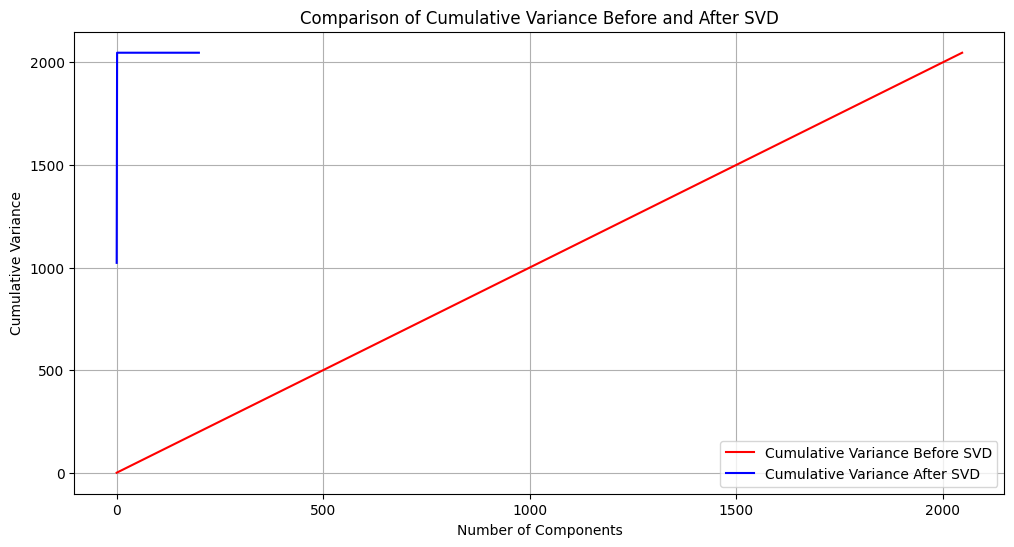

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Paths to the data files
scaled_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaled_drug_pair_features.h5"
svd_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/svd_drug_pair_features.h5"

# Load the original scaled data
with h5py.File(scaled_h5_file, "r") as h5f:
    X_train = h5f["X_train"][:]

# Load the SVD-transformed data
with h5py.File(svd_h5_file, "r") as h5f:
    X_train_svd = h5f["X_train"][:]

# Calculate the variance and cumulative variance
var_original = np.var(X_train, axis=0)
var_svd = np.var(X_train_svd, axis=0)
cum_var_original = np.cumsum(var_original)
cum_var_svd = np.cumsum(var_svd)

# Plot the cumulative variance
plt.figure(figsize=(12, 6))
plt.plot(cum_var_original, label='Cumulative Variance Before SVD', color='red')
plt.plot(cum_var_svd, label='Cumulative Variance After SVD', color='blue')
plt.title('Comparison of Cumulative Variance Before and After SVD')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import h5py

# File paths
original_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_split.h5"
scaled_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaled_drug_pair_features.h5"
svd_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/svd_drug_pair_features.h5"

# Function to print the shape of datasets in an HDF5 file
def print_dataset_shapes(h5_file):
    with h5py.File(h5_file, 'r') as h5f:
        for dataset_name in h5f.keys():
            print(f"Shape of {dataset_name} in {h5_file}: {h5f[dataset_name].shape}")

# Display the shapes
print("Original Data Shapes:")
print_dataset_shapes(original_h5_file)

print("\nScaled Data Shapes:")
print_dataset_shapes(scaled_h5_file)

print("\nSVD Transformed Data Shapes:")
print_dataset_shapes(svd_h5_file)


Original Data Shapes:
Shape of X_test in /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_split.h5: (134353, 2048)
Shape of X_train in /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_split.h5: (626978, 2048)
Shape of X_val in /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_split.h5: (134353, 2048)
Shape of y_test in /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_split.h5: (134353,)
Shape of y_train in /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_split.h5: (626978,)
Shape of y_val in /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_split.h5: (134353,)

Scaled Data Shapes:
Shape of X_test in /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaled_drug_pair_features.h5: (134353, 2048)
Shape of X_train in /content/drive/MyDrive/Colab Notebooks/DD

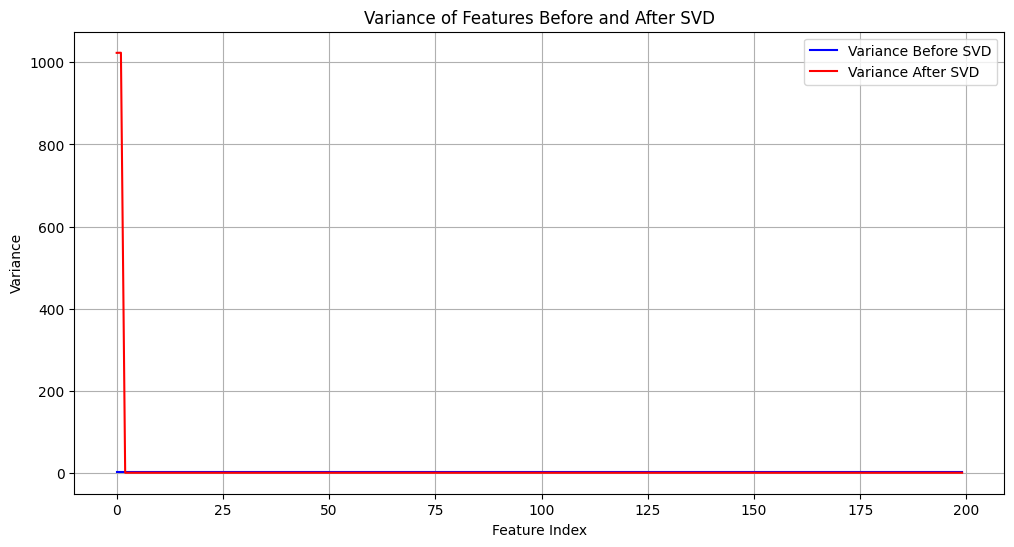

In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# File paths
scaled_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/scaled_drug_pair_features.h5"
svd_h5_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/svd_drug_pair_features.h5"

# Load scaled data
with h5py.File(scaled_h5_file, "r") as h5f:
    X_train = h5f["X_train"][:]

# Load SVD-transformed data
with h5py.File(svd_h5_file, "r") as h5f:
    X_train_svd = h5f["X_train"][:]

# Calculate the variance for each feature before and after SVD
variance_before = np.var(X_train, axis=0)
variance_after = np.var(X_train_svd, axis=0)

# Ensure even length for plotting
min_length = min(len(variance_before), len(variance_after))

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(variance_before[:min_length], label='Variance Before SVD', color='blue')
plt.plot(variance_after[:min_length], label='Variance After SVD', color='red')
plt.title('Variance of Features Before and After SVD')
plt.xlabel('Feature Index')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()


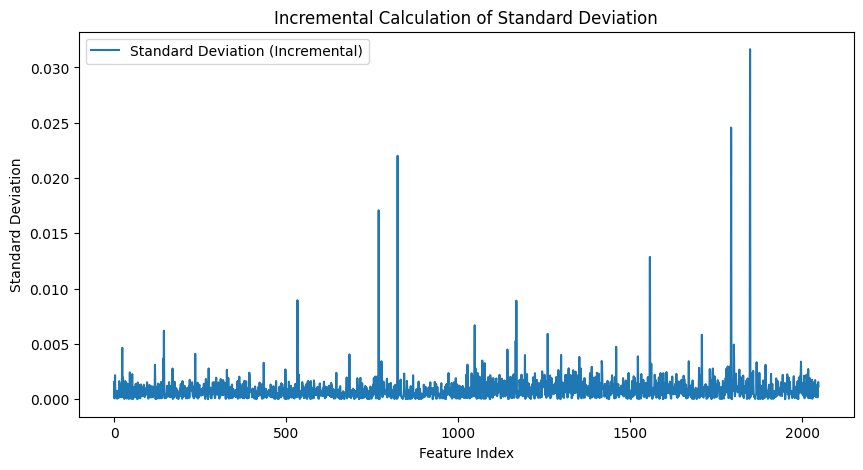

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def incremental_std(h5_path, dataset_key, chunks=10000):
    """ Calculate the mean and std dev incrementally to avoid memory overflow. """
    with h5py.File(h5_path, 'r') as file:
        data = file[dataset_key]
        n_samples = data.shape[0]
        scaler = StandardScaler()

        # Initialize variables for mean and standard deviation
        sample_mean = np.zeros(data.shape[1])
        sample_std = np.zeros(data.shape[1])
        for start_idx in range(0, n_samples, chunks):
            end_idx = min(start_idx + chunks, n_samples)
            subset = data[start_idx:end_idx]
            scaler.partial_fit(subset)  # Fit on chunks

        # Now calculate the mean/std on full data incrementally
        for start_idx in range(0, n_samples, chunks):
            end_idx = min(start_idx + chunks, n_samples)
            subset = data[start_idx:end_idx]
            # Incremental mean and variance (not using scaler.transform to avoid double memory consumption)
            sample_mean += (subset - scaler.mean_).sum(axis=0)
            sample_std += ((subset - scaler.mean_)**2).sum(axis=0)

        # Finalize mean and std computation
        sample_mean /= n_samples
        sample_std = np.sqrt(sample_std / n_samples)

    return sample_mean, sample_std

# File paths
h5_path = '/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_split.h5'
dataset_key = 'X_train'

# Calculate mean and std incrementally
mean, std = incremental_std(h5_path, dataset_key)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(std, label='Standard Deviation (Incremental)')
plt.title('Incremental Calculation of Standard Deviation')
plt.xlabel('Feature Index')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()
